# Decision tree for 0MA queries
## DuckDB, basic features

In [1]:
!pip install numpy==1.26.0
!pip install scikit-learn==1.5.0
!pip install statsmodels==0.14.2
!pip install matplotlib==3.9.0
!pip install seaborn==0.13.2
#!pip install torch==1.13.1
#!pip install tqdm==4.66.4
#!pip install dhg==0.9.4

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.tree import plot_tree
from sklearn.tree import export_text

In [3]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Serif'
plt.rcParams['figure.dpi'] = 600

### Import the data

In [4]:
file_path = 'results/features_times_DDB_infos.csv'
df = pd.read_csv(file_path)
df.head()

bench                query orig/rewr(med)            orig(med)  \
0  STATS              001-014           rewr  0.15307283401489258   
1  STATS        001-014-augA1           rewr  0.16620445251464844   
2  STATS        001-014-augA2           orig  0.16905856132507324   
3  STATS        001-014-augF1           rewr   0.1475837230682373   
4  STATS  001-014-augF1-augA1           rewr  0.16727375984191895   

              rewr(med)           stage0(med)          stage1(med)  \
0   0.09204626083374023  0.009572029113769531   0.0828394889831543   
1  0.061776161193847656  0.009177207946777344  0.05291175842285156   
2   0.20767855644226074  0.009125471115112305  0.19887375831604004   
3   0.09567809104919434   0.00930166244506836  0.08637642860412598   
4   0.07337379455566406  0.009343385696411133  0.06400871276855469   

   #relations  #conditions  #filters  ...  min(branching factors)  \
0           3            7         5  ...                       2   
1           3            7         5  ...                       1   
2           3            7         5  ...                       1   
3           3            7         5  ...                       2   
4           3            7         5  ...                       1   

   max(branching factors)  mean(branching factors)  median(branching factors)  \
0                       2                      2.0                        2.0   
1                       1                      1.0                        1.0   
2                       1                      1.0                        1.0   
3                       2                      2.0                        2.0   
4                       1                      1.0                        1.0   

   q25(branching factors)  q75(branching factors)  balancedness factor  \
0                     2.0                     2.0                  1.0   
1                     1.0                     1.0                  NaN   
2                     1.0                     1.0                  NaN   
3                     2.0                     2.0                  1.0   
4                     1.0                     1.0                  NaN   

                           container counts list  branching factors list  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]                     [2]   
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]                  [1, 1]   
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]                  [1, 1]   
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]                     [2]   
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]                  [1, 1]   

                                                text  
0  SELECT MIN(u.Id) FROM comments as c, votes as ...  
1  SELECT MIN(c.id) FROM comments as c, votes as ...  
2  SELECT MIN(v.id) FROM comments as c, votes as ...  
3  SELECT MIN(u.Id) FROM comments as c, votes as ...  
4  SELECT MIN(c.id) FROM comments as c, votes as ...  

[5 rows x 28 columns]

In [5]:
df.dtypes

bench                         object
query                         object
orig/rewr(med)                object
orig(med)                     object
rewr(med)                     object
stage0(med)                   object
stage1(med)                   object
#relations                     int64
#conditions                    int64
#filters                       int64
#joins                         int64
depth                          int64
min(container counts)          int64
max(container counts)          int64
mean(container counts)       float64
q25(container counts)        float64
median(container counts)     float64
q75(container counts)        float64
min(branching factors)         int64
max(branching factors)         int64
mean(branching factors)      float64
median(branching factors)    float64
q25(branching factors)       float64
q75(branching factors)       float64
balancedness factor          float64
container counts list         object
branching factors list        object
t

#### Delete those examples, where both methods gave a timeout

In [6]:
df[df["orig/rewr(med)"] == "-"].shape

(86, 28)

Some queries did not finish the evaluation within our timeout (100 sec). Therefore, we cannot conclude which variante is the better one and we delete those samples.

In cases where only one of the versions is giving a timeout, we set it the runtime to 100 to be able to work with them.

In [7]:
df = df[df["orig/rewr(med)"] != "-"]
df.shape

(2850, 28)

In [8]:
df[df["orig(med)"] == "TO"].shape

(178, 28)

In [9]:
df['orig(med)'] = df['orig(med)'].replace("TO", 100)

In [10]:
df[df["rewr(med)"] == "TO"].shape

(45, 28)

In [11]:
df['rewr(med)'] = df['rewr(med)'].replace("TO", 100)

In [12]:
df["orig(med)"] = df["orig(med)"].astype(float)

In [13]:
df["rewr(med)"] = df["rewr(med)"].astype(float)

#### Get the feature matrix

Get the features matrix X and the response variables y1 and y1, where once the rewritting time and the evaluation time are taken into consideration and once only the evaluation time. Additionally the response variables have to have numbers in it and we assign 1 = rewr and 0 = orig.

In [14]:
X = df.iloc[:, 7:24]
X.head()

#relations  #conditions  #filters  #joins  depth  min(container counts)  \
0           3            7         5       2      1                      1   
1           3            7         5       2      2                      1   
2           3            7         5       2      2                      1   
3           3            7         5       2      1                      1   
4           3            7         5       2      2                      1   

   max(container counts)  mean(container counts)  q25(container counts)  \
0                      3                1.133333                    1.0   
1                      3                1.133333                    1.0   
2                      3                1.133333                    1.0   
3                      3                1.133333                    1.0   
4                      3                1.133333                    1.0   

   median(container counts)  q75(container counts)  min(branching factors)  \
0                       1.0                    1.0                       2   
1                       1.0                    1.0                       1   
2                       1.0                    1.0                       1   
3                       1.0                    1.0                       2   
4                       1.0                    1.0                       1   

   max(branching factors)  mean(branching factors)  median(branching factors)  \
0                       2                      2.0                        2.0   
1                       1                      1.0                        1.0   
2                       1                      1.0                        1.0   
3                       2                      2.0                        2.0   
4                       1                      1.0                        1.0   

   q25(branching factors)  q75(branching factors)  
0                     2.0                     2.0  
1                     1.0                     1.0  
2                     1.0                     1.0  
3                     2.0                     2.0  
4                     1.0                     1.0

#### Log-transformations

This basic features do not need log transformations.

In [15]:
min_values = X.min()
max_values = X.max()
diff = max_values-min_values

pd.DataFrame({'Min': min_values, 'Max': max_values, 'Diff': diff})

Min   Max       Diff
#relations                 2.000000  11.0   9.000000
#conditions                2.000000  20.0  18.000000
#filters                   0.000000  16.0  16.000000
#joins                     1.000000  12.0  11.000000
depth                      1.000000   7.0   6.000000
min(container counts)      1.000000   1.0   0.000000
max(container counts)      2.000000   5.0   3.000000
mean(container counts)     1.047619   1.6   0.552381
q25(container counts)      1.000000   1.0   0.000000
median(container counts)   1.000000   1.0   0.000000
q75(container counts)      1.000000   1.0   0.000000
min(branching factors)     1.000000   6.0   5.000000
max(branching factors)     1.000000   6.0   5.000000
mean(branching factors)    1.000000   6.0   5.000000
median(branching factors)  1.000000   6.0   5.000000
q25(branching factors)     1.000000   6.0   5.000000
q75(branching factors)     1.000000   6.0   5.000000

In [16]:
X.hist(layout=(11, 3), figsize=(20, 25))
plt.show()

#### Classification response

Get the column(s) where we have "orig" or "rewr", depending on which method was faster. We now want to encode this as 0 (evaluating the original query faster) and 1 (evaluating the rewritten query faster).

In [17]:
mapping = {'orig': 0, 'rewr': 1}
y1 = df['orig/rewr(med)'].map(mapping)
#y1.head()

The number of appearances of original and rewritten is very balanced.

In [18]:
y1.value_counts()

orig/rewr(med)
1    1471
0    1379
Name: count, dtype: int64

In [19]:
count = y1.value_counts().tolist()[::-1] + ["-"]
count = pd.Series(count)
count.index = ["rewr", "orig", "equal"]
count

rewr     1379
orig     1471
equal       -
dtype: object

In [20]:
df["orig/rewr(med)"].value_counts()

orig/rewr(med)
rewr    1471
orig    1379
Name: count, dtype: int64

#### Train-validation-test split

We split the dataset such that each benchmark dataset is represented in the train and in the test set (stratification). We do a 80% train, 10% validation and 10% test split.

In [21]:
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, stratify=df["bench"], random_state=20)
X_val, X_test, y1_val, y1_test = train_test_split(X_test, y1_test, test_size=0.5, stratify=df.loc[X_test.index]["bench"], random_state=20)

### Facts about the test set and runtime differences

In [22]:
y1_test.value_counts()

orig/rewr(med)
1    151
0    134
Name: count, dtype: int64

In [23]:
#df["diff rewr-orig"] = df["rewr(med)"] - df["orig(med)"]
df["diff rewr-orig"] = np.where(
    df["rewr(med)"] == 100, -100,
    np.where(
        df["orig(med)"] == 100, 100, 
        df["rewr(med)"] - df["orig(med)"] 
    )
)

In [24]:
diff_rewr = df.loc[df["diff rewr-orig"] < 0]
diff_orig = df.loc[df["diff rewr-orig"] >= 0]

In [25]:
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']

diff_rewr["cut"] = pd.cut(abs(diff_rewr["diff rewr-orig"]), bins=bins, labels=labels)
diff_orig["cut"] = pd.cut(abs(diff_orig["diff rewr-orig"]), bins=bins, labels=labels)

table_rewr = diff_rewr.groupby('cut').size().reset_index(name = "rewr")
table_orig = diff_orig.groupby('cut').size().reset_index(name = "orig")

table = pd.merge(table_rewr, table_orig, on='cut', how='outer')
table = table.set_index('cut').T
#table.index = ['FP', 'FN']
table

/tmp/ipykernel_2484/1750407932.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_rewr["cut"] = pd.cut(abs(diff_rewr["diff rewr-orig"]), bins=bins, labels=labels)
/tmp/ipykernel_2484/1750407932.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_orig["cut"] = pd.cut(abs(diff_orig["diff rewr-orig"]), bins=bins, labels=labels)
/tmp/ipykernel_2484/1750407932.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False

cut   0.01  0.1    1   10  100   TO
rewr    55  366  340  360  172   45
orig    48  350  623  188  125  178

In [26]:
diff_rewr = df.loc[y1_test[y1_test == 1].index]
diff_orig = df.loc[y1_test[y1_test == 0].index]

In [27]:
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']

diff_rewr["cut"] = pd.cut(abs(diff_rewr["diff rewr-orig"]), bins=bins, labels=labels)
diff_orig["cut"] = pd.cut(abs(diff_orig["diff rewr-orig"]), bins=bins, labels=labels)

table_rewr = diff_rewr.groupby('cut').size().reset_index(name = "rewr")
table_orig = diff_orig.groupby('cut').size().reset_index(name = "orig")

table = pd.merge(table_rewr, table_orig, on='cut', how='outer')
table = table.set_index('cut').T
#table.index = ['FP', 'FN']
table

/tmp/ipykernel_2484/1750407932.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  table_rewr = diff_rewr.groupby('cut').size().reset_index(name = "rewr")
/tmp/ipykernel_2484/1750407932.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  table_orig = diff_orig.groupby('cut').size().reset_index(name = "orig")


cut   0.01  0.1   1  10  100  TO
rewr     7   46  28  38   14  18
orig     6   30  62  19   15   2

### Train a decision tree and observe the results on the test set

In [28]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_train)
y1_pred_dec_tree = clf.predict(X_test)

In [29]:
accuracy = accuracy_score(y1_test, y1_pred_dec_tree)
print(accuracy)
precision = precision_score(y1_test, y1_pred_dec_tree)
print(precision)
recall = recall_score(y1_test, y1_pred_dec_tree)
print(recall)
conf_matrix = confusion_matrix(y1_test, y1_pred_dec_tree)
conf_matrix

0.8105263157894737
0.888
0.7350993377483444


array([[120,  14],
       [ 40, 111]])

#### Get some statistics about the original runtimes, the rewritten runtimes, the decision runtimes and the true runtimes

In [30]:
test_set = df.loc[y1_test.index]

In [31]:
test_set["decision"] = y1_pred_dec_tree

In [32]:
test_set["faster runtime true"] = np.where(
    (test_set["orig/rewr(med)"] == "orig"), 
    test_set["orig(med)"], 
    test_set["rewr(med)"]
)

In [33]:
test_set["faster runtime dec"] = np.where(
    (test_set["decision"] == 0), 
    test_set["orig(med)"], 
    test_set["rewr(med)"]
)

In [34]:
summary_data = {
    "orig": [
        test_set["orig(med)"].sum(),
        test_set["orig(med)"].mean(),
        test_set["orig(med)"].min(),
        test_set["orig(med)"].max(),
        test_set["orig(med)"].median(),
        test_set["orig(med)"].std()
    ],
    "rewr": [
        test_set["rewr(med)"].sum(),
        test_set["rewr(med)"].mean(),
        test_set["rewr(med)"].min(),
        test_set["rewr(med)"].max(),
        test_set["rewr(med)"].median(),
        test_set["rewr(med)"].std()
    ],
    "dec": [
        test_set["faster runtime dec"].sum(),
        test_set["faster runtime dec"].mean(),
        test_set["faster runtime dec"].min(),
        test_set["faster runtime dec"].max(),
        test_set["faster runtime dec"].median(),
        test_set["faster runtime dec"].std()
    ],
    "true": [
        test_set["faster runtime true"].sum(),
        test_set["faster runtime true"].mean(),
        test_set["faster runtime true"].min(),
        test_set["faster runtime true"].max(),
        test_set["faster runtime true"].median(),
        test_set["faster runtime true"].std()
    ]
}

# Create a DataFrame using the summary data
summary_table = pd.DataFrame(
    summary_data,
    index=["sum", "mean","median", "std", "min", "max"]
)

# Display the table
summary_table

orig         rewr         dec        true
sum     2518.292882  1720.057306  804.020789  701.474102
mean       8.836115     6.035289    2.821126    2.461313
median     0.009418     0.037855    0.009418    0.009418
std      100.000000   100.000000  100.000000   92.171894
min        0.354668     0.390002    0.311879    0.291316
max       24.777895    18.581328   12.708677   10.814071

#### Inspection of the misclassifications

In [35]:
misclass = df.loc[X_test.index]
misclass.insert(0, 'true label', np.array(y1_test))
misclass.insert(0, 'pred label', y1_pred_dec_tree)
indices_not_equal = np.where(y1_test != y1_pred_dec_tree)[0]
misclass = misclass.iloc[indices_not_equal]
misclass

pred label  true label  bench                  query orig/rewr(med)  \
2041           0           1   SNAP   patents-tree01-augA1           rewr   
188            0           1  STATS    014-134-augF2-augA4           rewr   
411            0           1  STATS    033-137-augF1-augA3           rewr   
812            0           1  STATS    066-094-augF1-augA1           rewr   
755            0           1  STATS    061-053-augF2-augA3           rewr   
1210           1           0  STATS          098-124-augF1           orig   
771            0           1  STATS    062-129-augF2-augA4           rewr   
2747           0           1  HETIO    11-03-SpDlAdG-augA1           rewr   
645            0           1  STATS          052-029-augF2           rewr   
1442           0           1  STATS          118-074-augA3           rewr   
35             0           1  STATS    003-067-augF1-augA5           rewr   
1213           1           0  STATS    098-124-augF1-augA3           orig   
2897           1           0  HETIO  15-09-SpDtCbGcG-augA3           orig   
896            0           1  STATS    073-146-augF2-augA4           rewr   
1455           0           1  STATS    118-074-augF2-augA4           rewr   
915            1           0  STATS    074-072-augF2-augA5           orig   
228            0           1  STATS          018-065-augF1           rewr   
656            0           1  STATS    053-081-augF2-augA1           rewr   
874            0           1  STATS    072-099-augF1-augA2           rewr   
2450           0           1  HETIO    3-04-CcSEcCtD-augA6           rewr   
248            0           1  STATS    019-130-augF1-augA3           rewr   
333            1           0  STATS          027-132-augF1           orig   
1072           0           1  STATS    088-102-augF1-augA2           rewr   
719            1           0  STATS    059-061-augF1-augA1           orig   
340            1           0  STATS    027-132-augF2-augA2           orig   
1937           0           1   SNAP          google-path02           rewr   
620            1           0  STATS          050-106-augF1           orig   
2044           0           1   SNAP   patents-tree01-augA4           rewr   
2424           0           1  HETIO     3-01-CbGbCtD-augA1           rewr   
2425           0           1  HETIO     3-01-CbGbCtD-augA2           rewr   
34             0           1  STATS    003-067-augF1-augA4           rewr   
872            0           1  STATS          072-099-augF1           rewr   
259            0           1  STATS          020-027-augF1           rewr   
2748           0           1  HETIO    11-03-SpDlAdG-augA2           rewr   
868            0           1  STATS                072-099           rewr   
634            0           1  STATS          051-090-augF2           rewr   
446            0           1  STATS    036-100-augF2-augA2           rewr   
579            0           1  STATS    046-128-augF2-augA4           rewr   
1215           1           0  STATS    098-124-augF2-augA1           orig   
574            0           1  STATS    046-128-augF1-augA4           rewr   
1599           1           0  STATS    128-069-augF1-augA4           orig   
861            0           1  STATS          071-080-augA2           rewr   
119            1           0  STATS          010-063-augA2           orig   
337            1           0  STATS    027-132-augF1-augA4           orig   
1358           0           1  STATS                112-028           rewr   
813            0           1  STATS    066-094-augF1-augA2           rewr   
305            0           1  STATS    024-017-augF1-augA2           rewr   
1135           1           0  STATS                093-075           orig   
1217           1           0  STATS    098-124-augF2-augA3           orig   
878            0           1  STATS    072-099-augF2-augA2           rewr   
2736           0           1  HETIO    11-01-SpDlAeG-augA4           rewr   
40

In [36]:
print("Default font size:", plt.rcParams['font.size'])

Default font size: 10.0


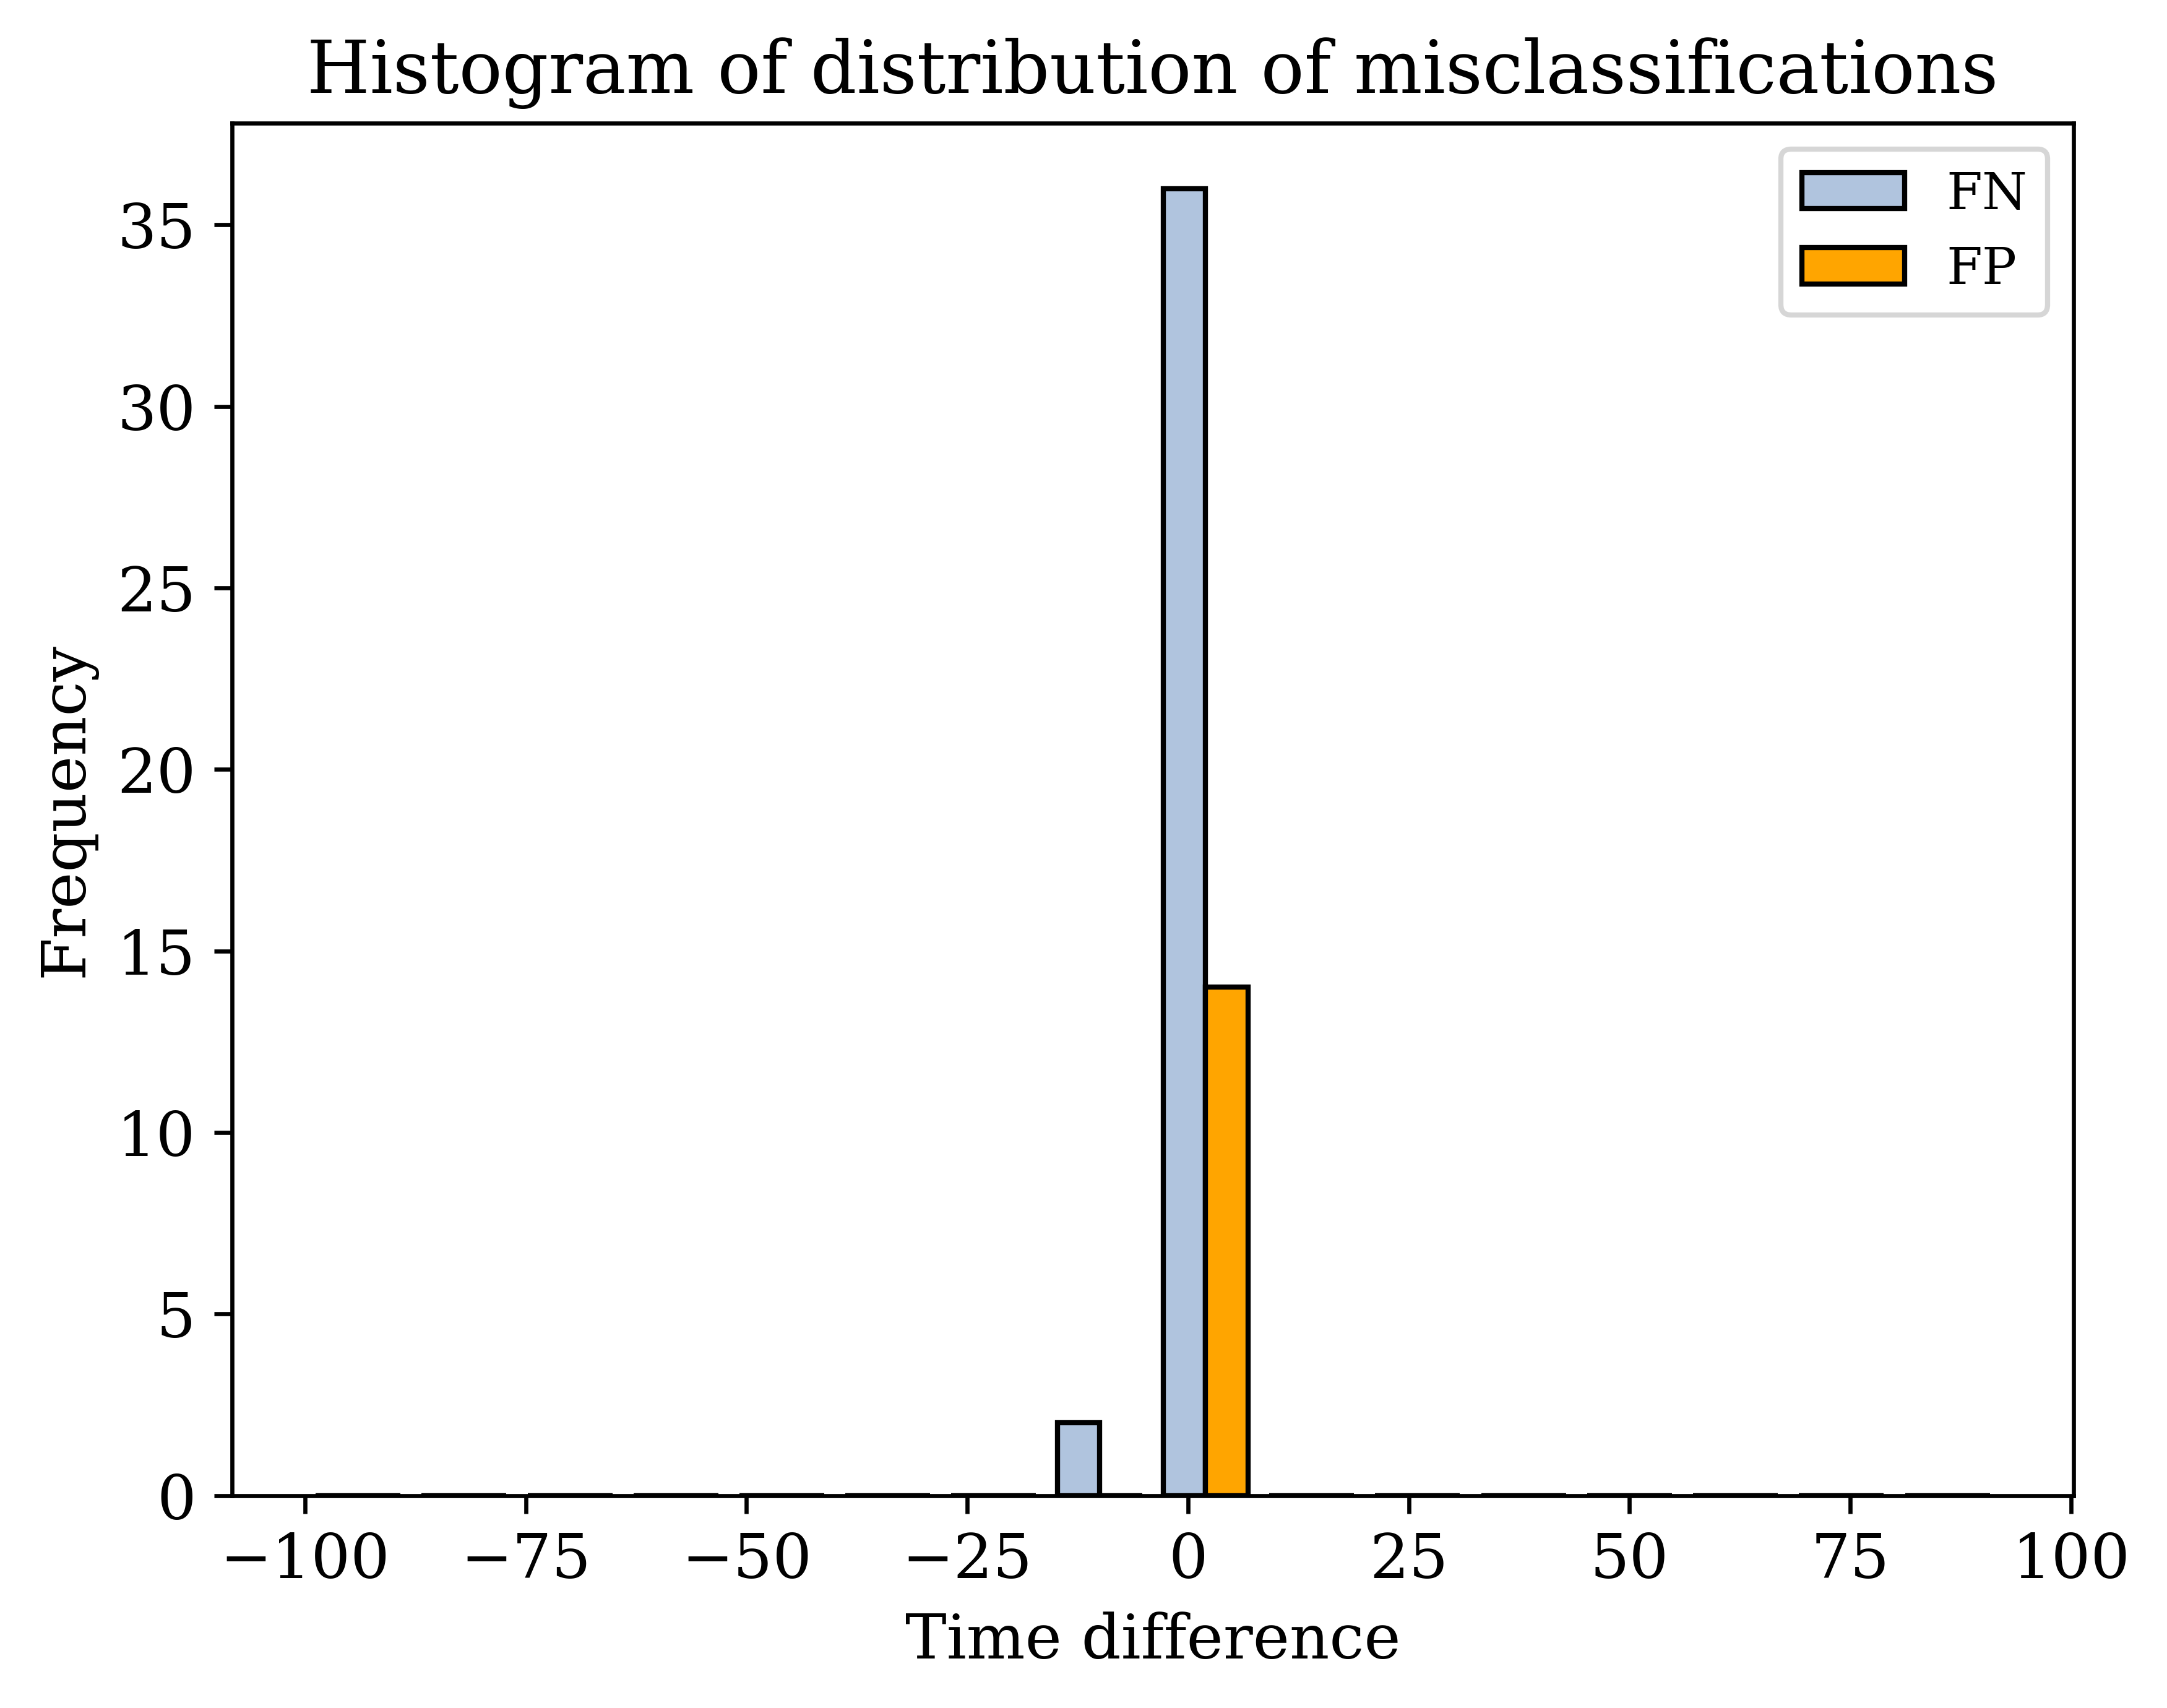

In [37]:
diff_0 = misclass[misclass['pred label'] == 0]['diff rewr-orig']
diff_1 = misclass[misclass['pred label'] == 1]['diff rewr-orig']

# Plotting the histogram
bins=list(range(-100, 101, 12))
plt.hist([diff_0, diff_1], bins=bins, edgecolor='black', color=['lightsteelblue', 'orange'], label=['FN', 'FP'])

# Adding labels and title
plt.xlabel('Time difference', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.title('Histogram of distribution of misclassifications', fontsize = 14)
plt.legend(title='')
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12)

plt.savefig('plots/DDB_0MA_dec_tree_misclass_hist.png')
# Show the plot
plt.show()

In [38]:
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']

misclass_1 = misclass[misclass["pred label"] == 1]
misclass_0 = misclass[misclass["pred label"] == 0]

misclass_1["cut"] = pd.cut(abs(misclass_1['diff rewr-orig']), bins=bins, labels=labels)
misclass_0["cut"] = pd.cut(abs(misclass_0['diff rewr-orig']), bins=bins, labels=labels)

table_1 = misclass_1.groupby('cut').size().reset_index(name='count_1')
table_0 = misclass_0.groupby('cut').size().reset_index(name='count_0')

table = pd.merge(table_1, table_0, on='cut', how='outer')
table = table.set_index('cut').T
table.index = ['FP', 'FN']
table

/tmp/ipykernel_2484/2371796600.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclass_1["cut"] = pd.cut(abs(misclass_1['diff rewr-orig']), bins=bins, labels=labels)
/tmp/ipykernel_2484/2371796600.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclass_0["cut"] = pd.cut(abs(misclass_0['diff rewr-orig']), bins=bins, labels=labels)
/tmp/ipykernel_2484/2371796600.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=

cut  0.01  0.1  1  10  100  TO
FP      3    3  8   0    0   0
FN      6   23  3   6    0   2

#### Statistical tests

In [39]:
test_set = df.loc[X_test.index]
test_set.insert(0, 'true label', np.array(y1_test))
test_set.insert(0, 'pred label', y1_pred_dec_tree)

In [40]:
test_set['pred(med)'] = np.where(test_set['pred label'] == 0, test_set['orig(med)'], test_set['rewr(med)'])
test_set.head()

pred label  true label  bench                      query orig/rewr(med)  \
776            0           0  STATS              063-109-augA4           orig   
1875           1           1  STATS        146-058-augF2-augA5           rewr   
2041           0           1   SNAP       patents-tree01-augA1           rewr   
1881           1           1   SNAP          dblp-path03-augA2           rewr   
2769           1           1  HETIO  12-02-SpDlApCcSEiPC-augA5           rewr   

       orig(med)  rewr(med)           stage0(med)         stage1(med)  \
776     0.252846   0.575767  0.016861915588378906    0.55918288230896   
1875  100.000000   0.441662  0.017879962921142578  0.4237823486328125   
2041  100.000000  58.042955  0.014292478561401367  58.029611110687256   
1881   11.271038   3.107694   0.01496267318725586   3.093395233154297   
2769    8.543117   0.387999   0.03162717819213867  0.3563718795776367   

      #relations  ...  mean(branching factors)  median(branching factors)  \
776            5  ...                      4.0                        4.0   
1875           6  ...                      5.0                        5.0   
2041           5  ...                      2.0                        2.0   
1881           4  ...                      1.5                        1.5   
2769          11  ...                      2.0                        1.0   

      q25(branching factors)  q75(branching factors)  balancedness factor  \
776                     4.00                    4.00             1.000000   
1875                    5.00                    5.00             1.000000   
2041                    2.00                    2.00             0.666667   
1881                    1.25                    1.75             1.000000   
2769                    1.00                    1.00             1.000000   

                                  container counts list  \
776   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
1875  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
2041                              [1, 1, 1, 1, 1, 2, 3]   
1881                              [1, 1, 1, 1, 1, 1, 2]   
2769  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

      branching factors list  \
776                      [4]   
1875                     [5]   
2041                  [2, 2]   
1881                  [1, 2]   
2769         [1, 1, 1, 1, 6]   

                                                   text  diff rewr-orig  \
776   SELECT MIN(p.id) FROM comments as c, postLinks...        0.322921   
1875  SELECT MIN(u.id) FROM posts as p, postLinks as...      100.000000   
2041  SELECT MIN(p2.fromnode) FROM patents p1, paten...      100.000000   
1881  select MIN(p3.fromnode) from dblp p1, dblp p2,...       -8.163344   
2769  SELECT MIN(pa.sid) FROM symptom s, presents p,...       -8.155118   

       pred(med)  
776     0.252846  
1875    0.441662  
2041  100.000000  
1881    3.107694  
2769    0.387999  

[5 rows x 32 columns]

The Wilcoxon rank test is to compare medians (of dependent groups).  
The Nullhypothesis is that the medians are equal. If the p-value is smaller than a chosen alpha value, we can reject the null and say that the median with only original runtimes is significantly different to the median of the chosen versions.

In [41]:
w_stat, p_val = stats.wilcoxon(test_set["orig(med)"], test_set["pred(med)"])

print(f"Wilcoxon statistic: {w_stat}")
print(f"P-value: {p_val}")

Wilcoxon statistic: 403.0
P-value: 3.072091005736095e-18


The paired sample t-test is to compare means (of dependent groups).  
The Nullhypothesis is that the means are equal. If the p-value is smaller than a chosen alpha value, we can reject the null and say that the mean with only original runtimes is significantly different to the mean of the chosen versions.

In [42]:
t_stat, p_val = stats.ttest_rel(test_set["orig(med)"], test_set["pred(med)"])

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_val}")

T-statistic: 5.153501552631754
P-value: 4.794452463031424e-07


#### Important features using Gini importance

In [43]:
feature_names = X.columns.tolist()
feature_importances = clf.feature_importances_
df_importances = pd.DataFrame(data=feature_importances, index=feature_names, columns=["Importance"])
df_importances.T

#relations  #conditions  #filters    #joins     depth  \
Importance    0.052881     0.079281   0.17591  0.076727  0.001588   

            min(container counts)  max(container counts)  \
Importance                    0.0               0.061395   

            mean(container counts)  q25(container counts)  \
Importance                0.461567                    0.0   

            median(container counts)  q75(container counts)  \
Importance                       0.0                    0.0   

            min(branching factors)  max(branching factors)  \
Importance                0.003611                0.006941   

            mean(branching factors)  median(branching factors)  \
Importance                  0.01152                    0.01846   

            q25(branching factors)  q75(branching factors)  
Importance                0.009603                0.040516

In [44]:
df_importances_sorted = df_importances.sort_values(by='Importance', ascending=False)  # Use ascending=True for ascending order
df_importances_sorted

Importance
mean(container counts)       0.461567
#filters                     0.175910
#conditions                  0.079281
#joins                       0.076727
max(container counts)        0.061395
#relations                   0.052881
q75(branching factors)       0.040516
median(branching factors)    0.018460
mean(branching factors)      0.011520
q25(branching factors)       0.009603
max(branching factors)       0.006941
min(branching factors)       0.003611
depth                        0.001588
min(container counts)        0.000000
median(container counts)     0.000000
q75(container counts)        0.000000
q25(container counts)        0.000000

#### Visualization of the decision tree

In [45]:
clf.tree_.max_depth

19

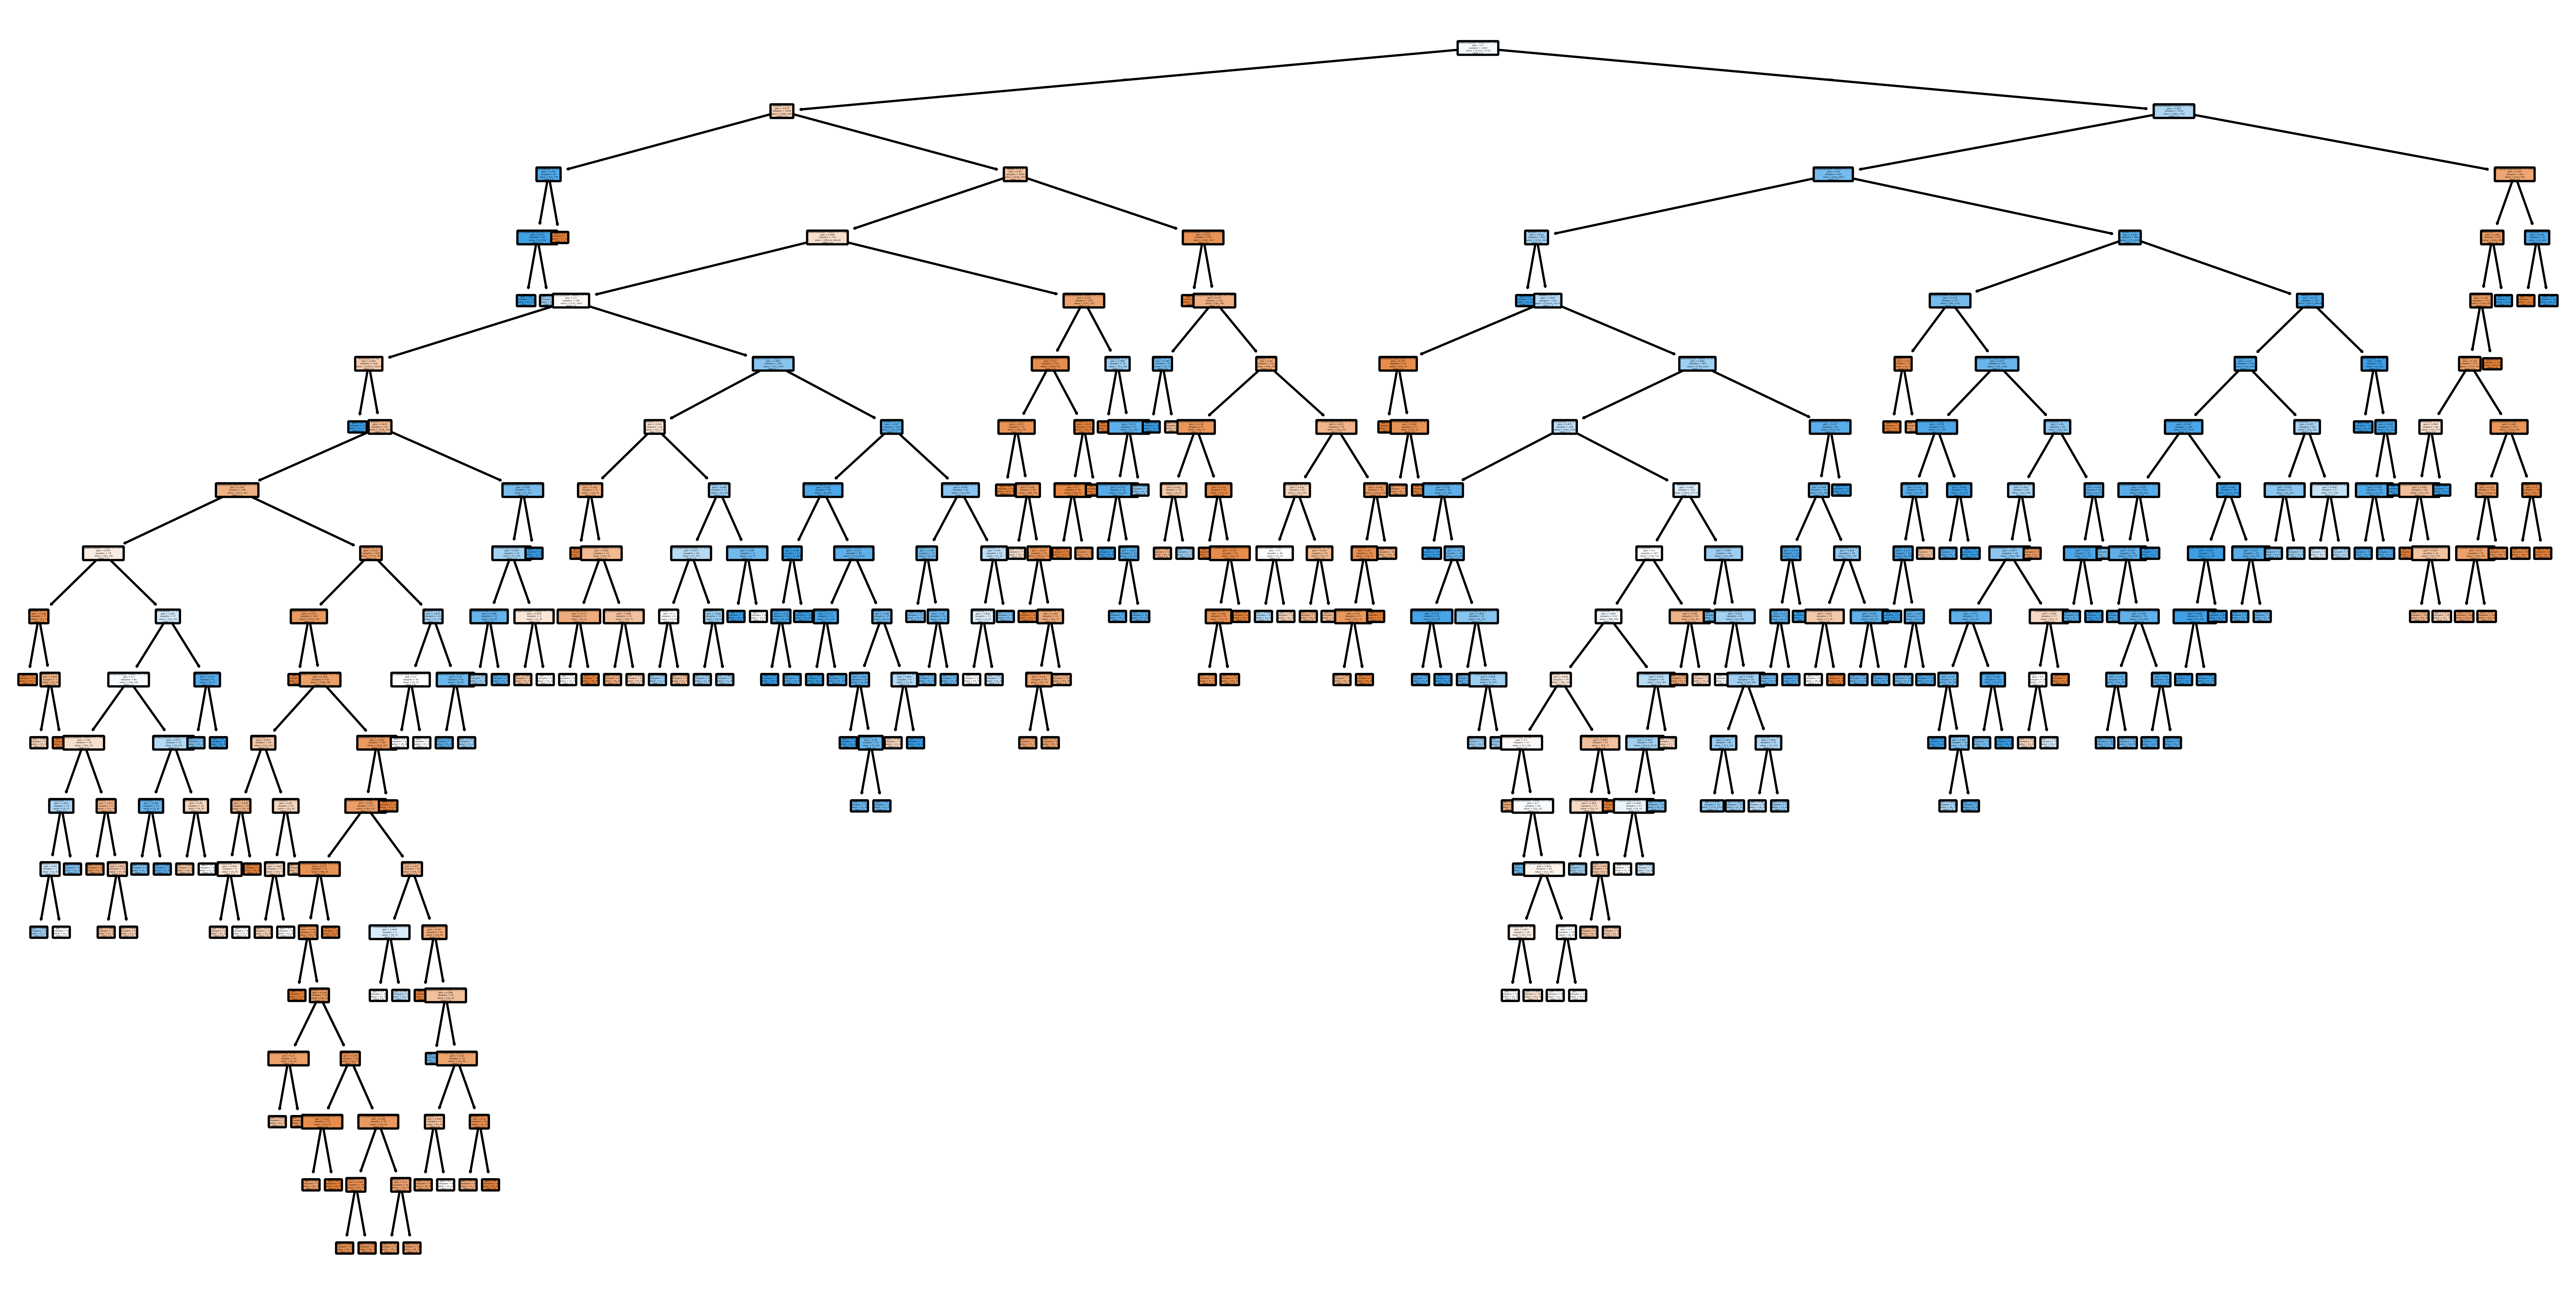

In [46]:
plt.figure(figsize=(20,10))  # Customize the size as needed
plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=["0","1"], rounded=True)
plt.savefig('plots/DDB_0MA_dec_tree_vis.png')
plt.show()

#### Plots of the runtime distributions

Plots of the distribution of the orders of magnitude for the final model on the test set in comparison to the original and rewritten plots

/tmp/ipykernel_2484/3857058850.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_orig = test_set.groupby(['interval orig', 'bench']).size().unstack(fill_value=0)
/tmp/ipykernel_2484/3857058850.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_rewr = test_set.groupby(['interval rewr', 'bench']).size().unstack(fill_value=0)
/tmp/ipykernel_2484/3857058850.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warni

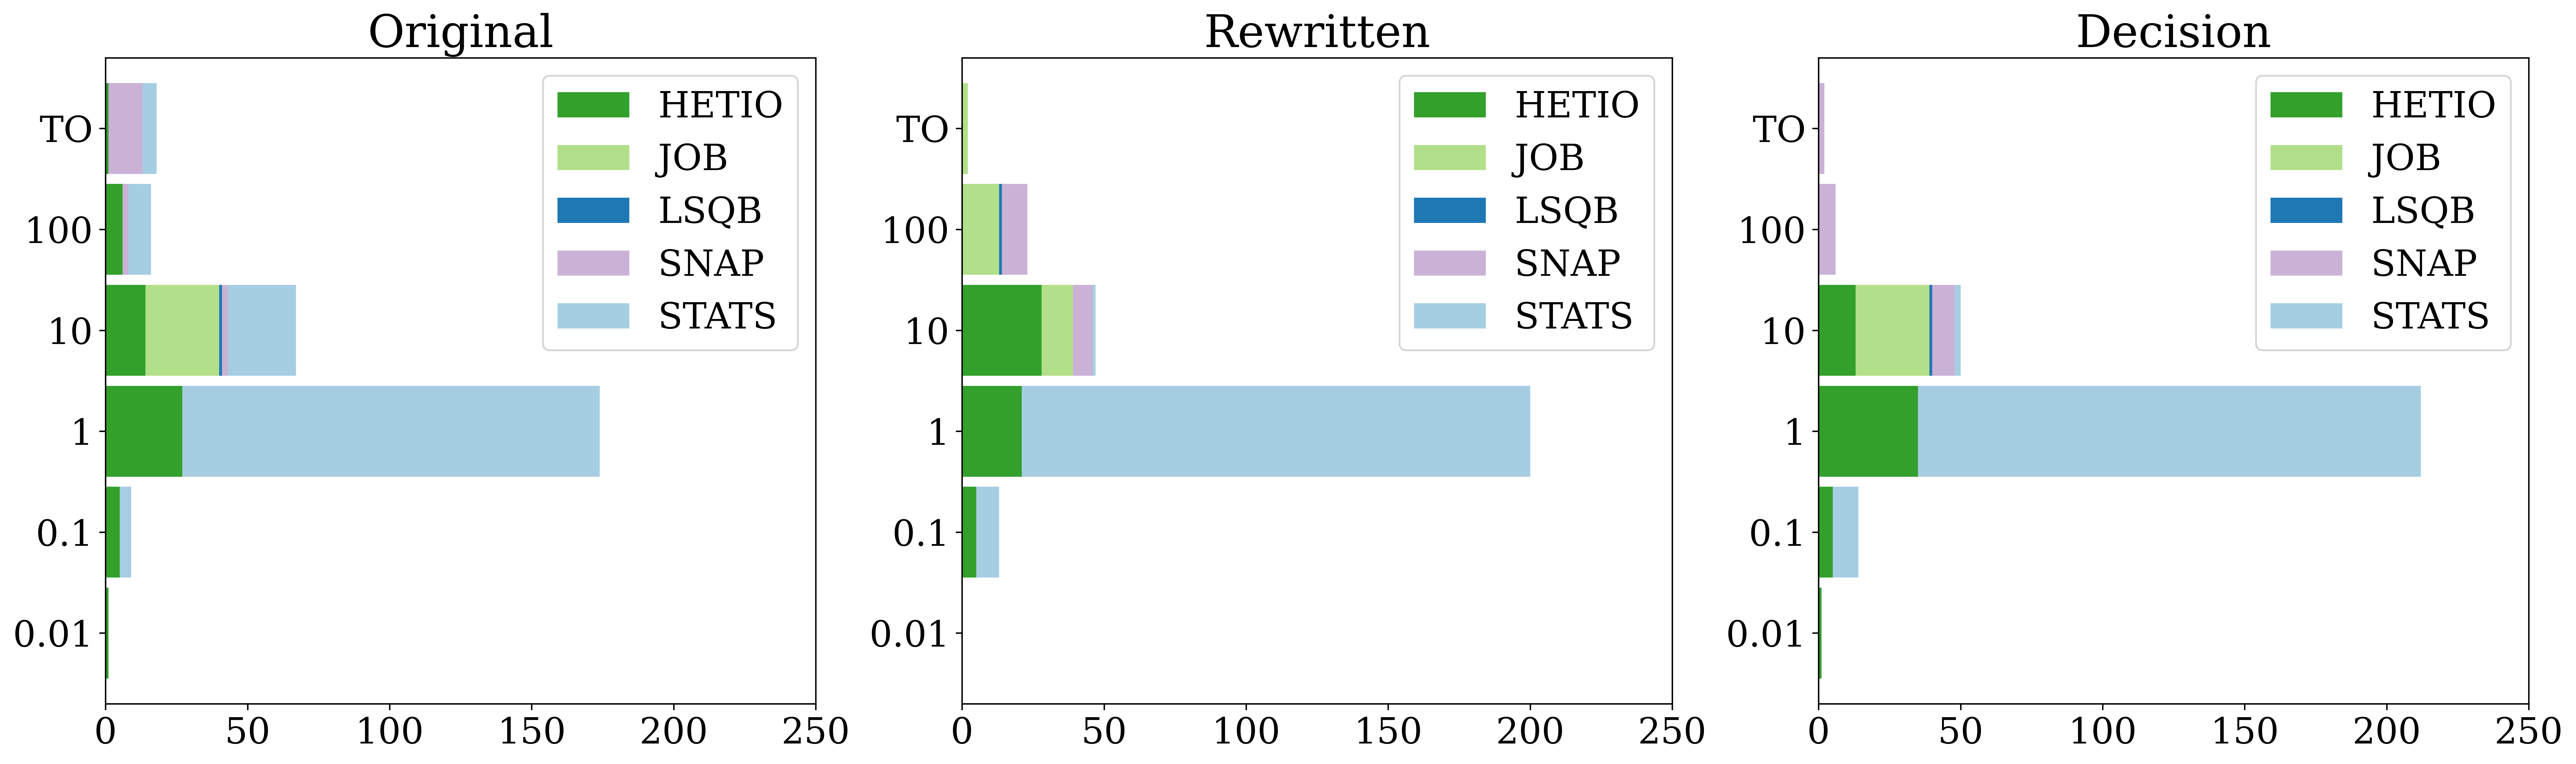

In [47]:
test_set["orig(med)"] = test_set['orig(med)'].astype("float64")
test_set["rewr(med)"] = test_set['rewr(med)'].astype("float64")
test_set["pred(med)"] = test_set['pred(med)'].astype("float64")
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']
test_set['interval orig'] = pd.cut(test_set['orig(med)'], bins=bins, labels=labels)
test_set['interval rewr'] = pd.cut(test_set['rewr(med)'], bins=bins, labels=labels)
test_set['interval pred'] = pd.cut(test_set['pred(med)'], bins=bins, labels=labels)

grouped_orig = test_set.groupby(['interval orig', 'bench']).size().unstack(fill_value=0)
grouped_rewr = test_set.groupby(['interval rewr', 'bench']).size().unstack(fill_value=0)
grouped_pred = test_set.groupby(['interval pred', 'bench']).size().unstack(fill_value=0)

paired_colors = [
    '#a6cee3', '#1f78b4', '#b2df8a', '#33a02c',
    '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00',
    '#cab2d6', '#6a3d9a', '#ffff99', '#b15928'
]

category_colors = {
    'HETIO': paired_colors[3],
    'JOB': paired_colors[2],
    'LSQB': paired_colors[1],
    'SNAP': paired_colors[8],
    'STATS': paired_colors[0]
}

colors = [category_colors[col] for col in grouped_orig.columns]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

fontsize = 20
titlesize = 25
xlim = 250

# Plot for 'orig mean'
grouped_orig.plot(kind='barh', stacked=True, color=colors, ax=ax1, width = 0.9)
ax1.set_xlim(0,xlim)
#ax1.set_xlabel('Count', fontsize=fontsize)  # Increase font size for x-axis label
#ax1.set_ylabel('Order of magnitude', fontsize=fontsize)  # Increase font size for y-axis label
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_title('Original', fontsize=titlesize)  # Increase font size for title
ax1.legend(fontsize=fontsize)  # Increase font size for legend
ax1.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'rewr mean'
grouped_rewr.plot(kind='barh', stacked=True, color=colors, ax=ax2, width = 0.9)
#ax2.set_xlabel('Count', fontsize=fontsize)
#ax2.set_ylabel('Order of magnitude', fontsize=fontsize)
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('Rewritten', fontsize=titlesize)
ax2.legend(fontsize=fontsize)  
ax2.set_xlim(0,xlim)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'pred mean'
grouped_pred.plot(kind='barh', stacked=True, color=colors, ax=ax3, width = 0.9)
#ax3.set_xlabel('Count', fontsize=fontsize)
#ax3.set_ylabel('Order of magnitude', fontsize=fontsize)
ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.set_title('Decision', fontsize=titlesize)
ax3.legend(fontsize=fontsize)  
ax3.set_xlim(0,xlim)
ax3.tick_params(axis='both', which='major', labelsize=fontsize)

plt.tight_layout()
plt.savefig('plots/DDB_0MA_runtimes_color_big.png')
plt.show()

/tmp/ipykernel_2484/2959646478.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_orig = test_set.groupby(['interval orig', 'bench']).size().unstack(fill_value=0)
/tmp/ipykernel_2484/2959646478.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_rewr = test_set.groupby(['interval rewr', 'bench']).size().unstack(fill_value=0)
/tmp/ipykernel_2484/2959646478.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warni

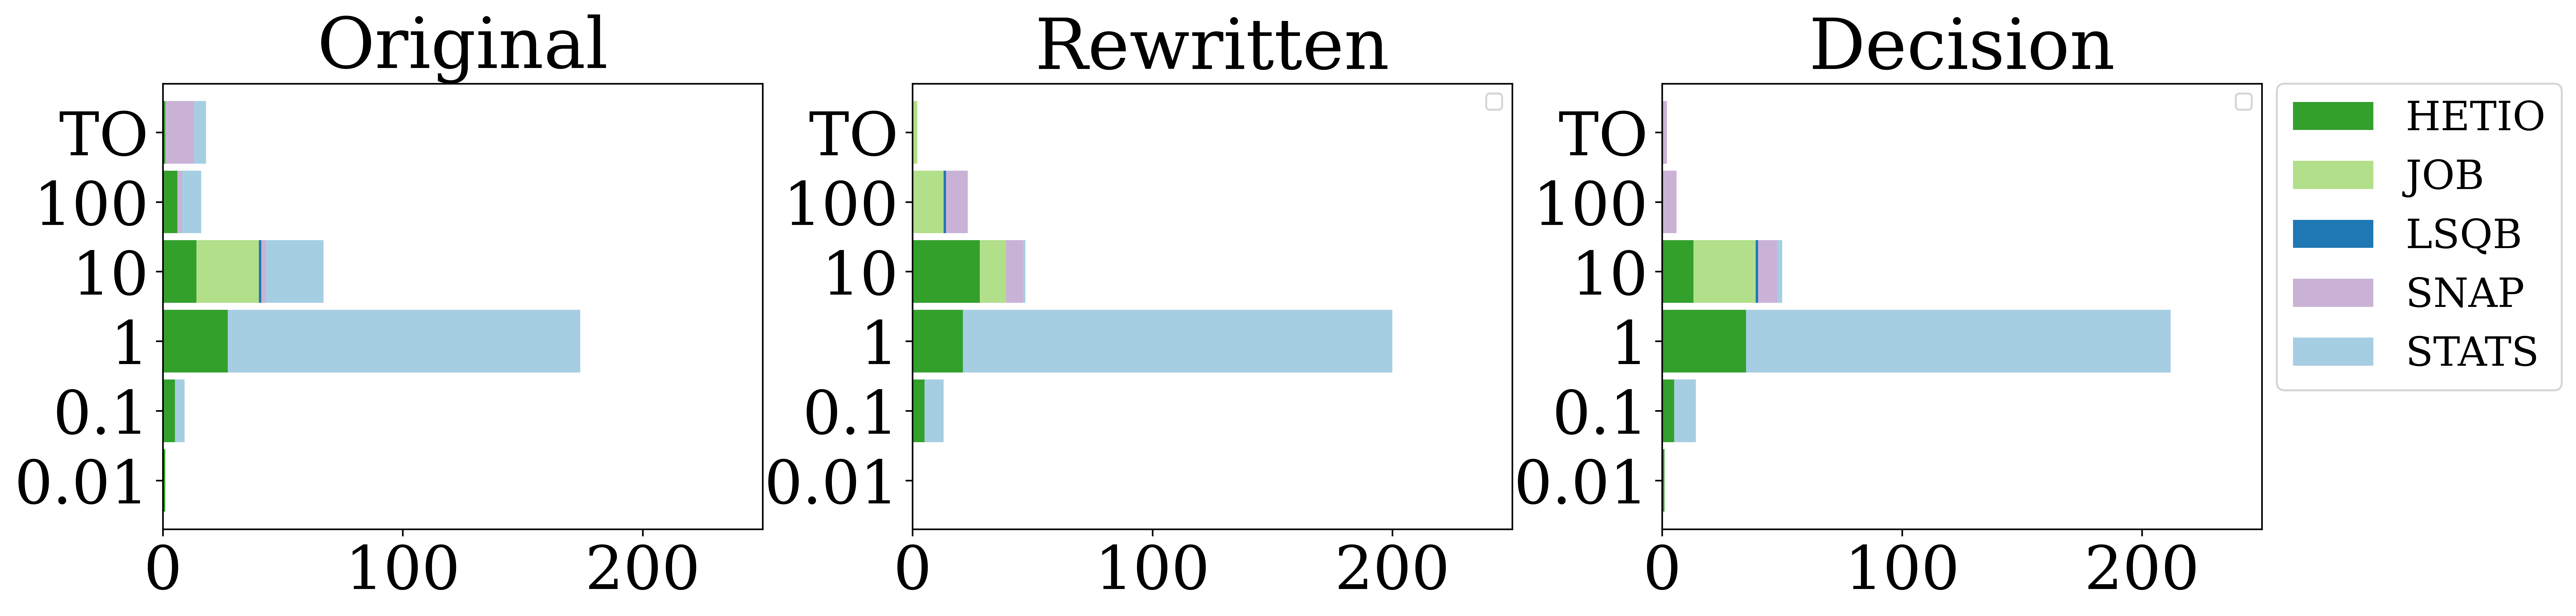

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming test_set is already defined and populated
test_set["orig(med)"] = test_set['orig(med)'].astype("float64")
test_set["rewr(med)"] = test_set['rewr(med)'].astype("float64")
test_set["pred(med)"] = test_set['pred(med)'].astype("float64")

bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']
test_set['interval orig'] = pd.cut(test_set['orig(med)'], bins=bins, labels=labels)
test_set['interval rewr'] = pd.cut(test_set['rewr(med)'], bins=bins, labels=labels)
test_set['interval pred'] = pd.cut(test_set['pred(med)'], bins=bins, labels=labels)

grouped_orig = test_set.groupby(['interval orig', 'bench']).size().unstack(fill_value=0)
grouped_rewr = test_set.groupby(['interval rewr', 'bench']).size().unstack(fill_value=0)
grouped_pred = test_set.groupby(['interval pred', 'bench']).size().unstack(fill_value=0)

paired_colors = [
    '#a6cee3', '#1f78b4', '#b2df8a', '#33a02c',
    '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00',
    '#cab2d6', '#6a3d9a', '#ffff99', '#b15928'
]

category_colors = {
    'HETIO': paired_colors[3],
    'JOB': paired_colors[2],
    'LSQB': paired_colors[1],
    'SNAP': paired_colors[8],
    'STATS': paired_colors[0]
}

colors = [category_colors[col] for col in grouped_orig.columns]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))

fontsize = 30
titlesize = 35
xlim = 250

# Plot for 'orig mean'
grouped_orig.plot(kind='barh', stacked=True, color=colors, ax=ax1, width = 0.9)
ax1.set_xlim(0, xlim)
#ax1.set_xlabel('Count', fontsize=fontsize)  # Increase font size for x-axis label
#ax1.set_ylabel('Order of magnitude', fontsize=fontsize)  # Increase font size for y-axis label
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_title('Original', fontsize=titlesize)
#ax1.legend(title='Benchmark', fontsize=fontsize)  # Removed individual legend for this subplot
ax1.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'rewr mean'
grouped_rewr.plot(kind='barh', stacked=True, color=colors, ax=ax2, width = 0.9)
ax2.set_xlabel('')
ax2.set_ylabel('')
#ax2.set_xlabel('Count', fontsize=fontsize)
#ax2.set_ylabel('Order of magnitude', fontsize=fontsize)
ax2.set_title('Rewritten', fontsize=titlesize)
#ax2.legend(title='Benchmark', fontsize=fontsize)  # Removed individual legend for this subplot
ax2.legend('')
ax2.set_xlim(0, xlim)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'pred mean'
grouped_pred.plot(kind='barh', stacked=True, color=colors, ax=ax3, width = 0.9)
ax3.set_xlabel('')
ax3.set_ylabel('')
#ax3.set_xlabel('Count', fontsize=fontsize)
#ax3.set_ylabel('Order of magnitude', fontsize=fontsize)
ax3.set_title('Decision', fontsize=titlesize)
#ax3.legend(title='Benchmark', fontsize=fontsize)  # Removed individual legend for this subplot
ax3.legend('')
ax3.set_xlim(0, xlim)
ax3.tick_params(axis='both', which='major', labelsize=fontsize)

# Add a combined legend outside the plots
handles, labels = ax1.get_legend_handles_labels()  # Use handles from the first subplot
ax1.legend(handles, labels, fontsize=20, loc='upper right', bbox_to_anchor=(4, 1), borderaxespad=0.)

# Adjust layout to make room for the legend
#plt.tight_layout()
plt.subplots_adjust(wspace = 0.25, right=0.85)  # Adjust this value to make room for the legend

plt.savefig('plots/DDB_0MA_runtimes_color.png') 
plt.show()


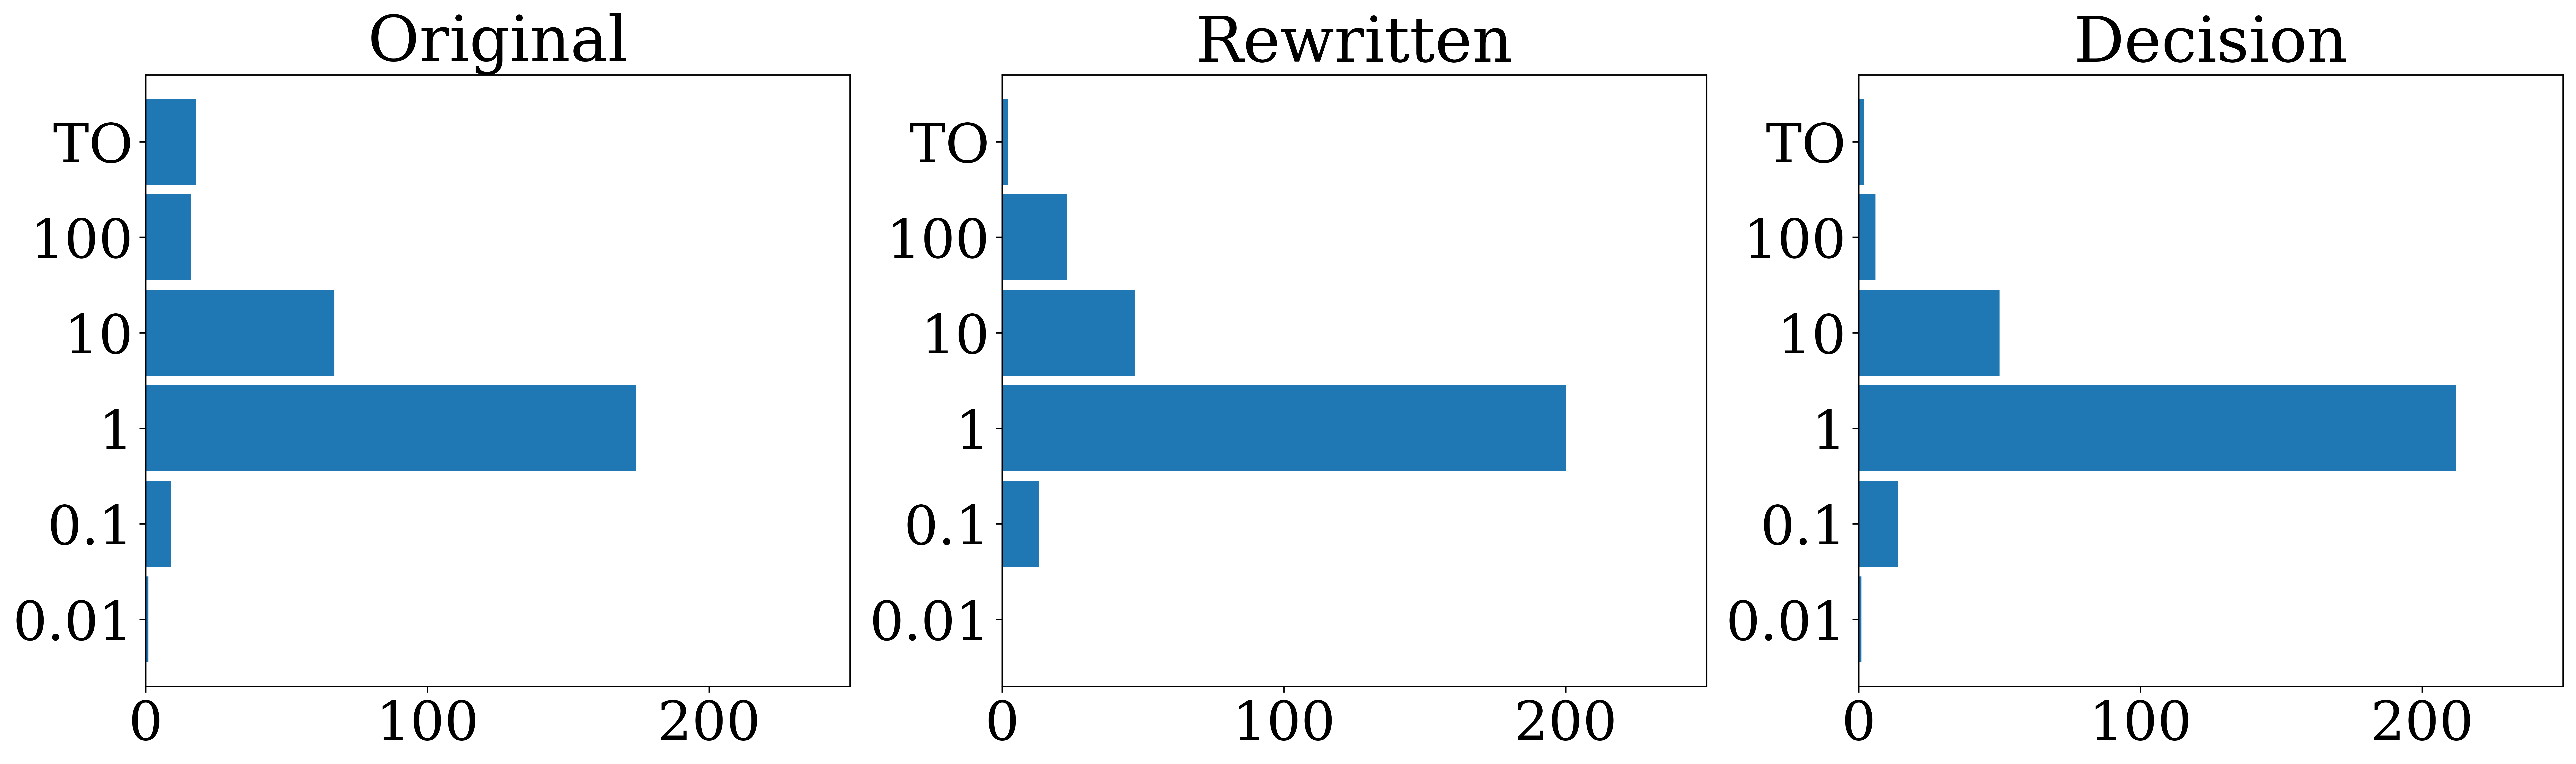

In [49]:
test_set["orig(med)"] = test_set['orig(med)'].astype("float64")
test_set["rewr(med)"] = test_set['rewr(med)'].astype("float64")
test_set["pred(med)"] = test_set['pred(med)'].astype("float64")
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']
test_set['interval orig'] = pd.cut(test_set['orig(med)'], bins=bins, labels=labels)
test_set['interval rewr'] = pd.cut(test_set['rewr(med)'], bins=bins, labels=labels)
test_set['interval pred'] = pd.cut(test_set['pred(med)'], bins=bins, labels=labels)

grouped_orig = test_set['interval orig'].value_counts().sort_index()
grouped_rewr = test_set['interval rewr'].value_counts().sort_index()
grouped_pred = test_set['interval pred'].value_counts().sort_index()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

fontsize = 30
titlesize = 35
xlim = 250

# Plot for 'orig mean'
grouped_orig.plot(kind='barh', stacked=True, ax=ax1, width = 0.9)
ax1.set_xlim(0,xlim)
#ax1.set_xlabel('Count', fontsize=fontsize)  # Increase font size for x-axis label
#ax1.set_ylabel('Order of magnitude', fontsize=fontsize)  # Increase font size for y-axis label
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_title('Original', fontsize=titlesize)  # Increase font size for title
ax1.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'rewr mean'
grouped_rewr.plot(kind='barh', stacked=True, ax=ax2, width = 0.9)
#ax2.set_xlabel('Count', fontsize=fontsize)
#ax2.set_ylabel('Order of magnitude', fontsize=fontsize)
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('Rewritten', fontsize=titlesize)
ax2.set_xlim(0,xlim)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'pred mean'
grouped_pred.plot(kind='barh', stacked=True, ax=ax3, width = 0.9)
#ax3.set_xlabel('Count', fontsize=fontsize)
#ax3.set_ylabel('Order of magnitude', fontsize=fontsize)
ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.set_title('Decision', fontsize=titlesize)
ax3.set_xlim(0,xlim)
ax3.tick_params(axis='both', which='major', labelsize=fontsize)

plt.tight_layout()
plt.savefig('plots/DDB_0MA_runtimes.png')
plt.show()